## Прогнозирование стоимости автомобиля по характеристикам



Импортируем необходимые библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Настройка Pandas
pd.set_option('display.max_rows', 400) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
RANDOM_SEED = 42

Данные мы собирали отдельно, а затем объединили их в один csv-файл. Просто подгрузим его.  
Парсинг сайта auto.ru: https://github.com/Powerofpowder/parsing

## Data

Объединение датасетов с разнных сайтов

In [5]:
DIR  = '../input/car-price-prediction-datasets/'

auto_ru_df = pd.read_csv(DIR+'auto_ru_cars.csv')
drom_ru_df = pd.read_csv(DIR+'drom.csv')
avito_df = pd.read_csv(DIR+'avito_cars.csv')
car_ru_df = pd.read_csv(DIR+'df_car_ru.csv')
test_df = pd.read_csv(DIR+'test.csv')

# в поле price есть пропуски, удалим эти строки
auto_ru_df = auto_ru_df.dropna(subset = ['price'])

# добавляем колонку источника информации о машине (сайт)
auto_ru_df['source'] = 'auto_ru'
drom_ru_df['source'] = 'drom_ru'
avito_df['source'] = 'avito'
car_ru_df['source'] = 'car_ru'
test_df['source'] = 'test_dataset'

# изменяем название колонок, чтобы их объединить без появления повторяющихся названий признаков
auto_ru_df = auto_ru_df.rename(columns={"body_type": "bodyType", "таможня": "Таможня"}, errors="raise")
avito_df = avito_df.rename(columns={"Price": "price"}, errors="raise")

# объединяем датасеты с разных сайтов в один с названием df
df = pd.concat([auto_ru_df, drom_ru_df, avito_df, car_ru_df, test_df], ignore_index=True, sort=False)

# создаем новые айди
df.id = [i for i in range(1, len(df)+1)]

In [6]:
df

bodyType brand       color  fuelType modelDate  \
0        ALLROAD_5_DOORS   BMW      200204    DIESEL         0   
1        ALLROAD_5_DOORS   BMW      22A0F8  GASOLINE         0   
2        ALLROAD_5_DOORS   BMW      200204    DIESEL         0   
3        ALLROAD_5_DOORS   BMW      040001  GASOLINE         0   
4        ALLROAD_5_DOORS   BMW      97948F  GASOLINE         0   
...                  ...   ...         ...       ...       ...   
21093              седан   BMW      чёрный    бензин      2013   
21094  внедорожник 5 дв.   BMW      чёрный    дизель      2013   
21095              седан   BMW      чёрный    бензин      2002   
21096              седан   BMW  коричневый    бензин      2009   
21097  внедорожник 5 дв.   BMW      чёрный    бензин      2007   

                                    name numberOfDoors productionDate  \
0                 20d 2.0d AT (177 л.с.)             5           2012   
1                 None 4.4 AT (575 л.с.)             5           2018   
2                 20d 2.0d AT (184 л.с.)             5           2012   
3                  35i 3.0 AT (306 л.с.)             5           2014   
4           20i xDrive 2.0 AT (184 л.с.)             5           2014   
...                                  ...           ...            ...   
21093             520i 2.0 AT (184 л.с.)             4           2013   
21094         30d 3.0d AT (249 л.с.) 4WD             5           2016   
21095        525xi 2.5 AT (218 л.с.) 4WD             4           2006   
21096  528i xDrive 2.0 AT (245 л.с.) 4WD             4           2012   
21097          50i 4.4 AT (407 л.с.) 4WD             5           2010   

      vehicleTransmission engineDisplacement enginePower  \
0               AUTOMATIC            2.0d AT         177   
1               AUTOMATIC             4.4 AT         575   
2               AUTOMATIC            2.0d AT         184   
3               AUTOMATIC             3.0 AT         306   
4               AUTOMATIC             2.0 AT         184   
...                   ...                ...         ...   
21093      автоматическая            2.0 LTR     184 N12   
21094      автоматическая            3.0 LTR     249 N12   
21095      автоматическая            2.5 LTR     218 N12   
21096      автоматическая            2.0 LTR     245 N12   
21097      автоматическая            4.4 LTR     407 N12   

                                             description mileage  \
0      Отличный ухоженный автомобиль, с очень хорошей...  164000   
1      Продам Машину в идеальном состоянии и минималь...   13500   
2      Автомобиль в идеальном состоянии, полностью об...  135000   
3      Продам  BMW X5 в отличном состоянии.\nЯ второй...   89000   
4      Авто в отличном состоянии, без ДТП, все в родн...  146000   
...                                                  ...     ...   
21093  Продаётся BMW 5 F10 Рестайлинг\n2 бережливых в...   98000   
21094  ✪  ✪  ✪  ✪  ✪  ✪  ✪  ✪  ✪ ✪  ✪  ✪  ✪  ✪  ✪  ✪ ...  169615   
21095  Продам полностью обслуженный автомобиль , сдел...  180000   
21096  Продаю отличный авто. Полностью обслужен. Лучш...  137500   
21097  Максимальная комплектация. 22.09.2019 сделано ...   89905   

                                            Комплектация           Привод  \
0                                                    NaN  ALL_WHEEL_DRIVE   
1                                                    NaN  ALL_WHEEL_DRIVE   
2                                                    NaN  ALL_WHEEL_DRIVE   
3                                                    NaN  ALL_WHEEL_DRIVE   
4                                                    NaN  ALL_WHEEL_DRIVE   
...                                                  ...              ...   
21093  ['[{"name":"Комфорт","values":["Круиз-контроль...           задний   
21094  ['[{"name":"Комфорт","values":["Круиз-контроль...           полный   
21095  ['[{"name":"Комфорт","values":["Круиз-контроль...           полный   
21096  ['[{"name":"Комфорт","values":[

или читаем уже объединеный датасет

In [7]:
# df = pd.read_csv(DIR+'united_df.csv')

In [8]:
# смотрим, какие признаки получились
for i, el in enumerate(df.columns):
    print(i, el)

0 bodyType
1 brand
2 color
3 fuelType
4 modelDate
5 name
6 numberOfDoors
7 productionDate
8 vehicleTransmission
9 engineDisplacement
10 enginePower
11 description
12 mileage
13 Комплектация
14 Привод
15 Руль
16 Состояние
17 Владельцы
18 ПТС
19 Таможня
20 Владение
21 id
22 price
23 source
24 Unnamed: 0
25 vehicleConfiguration


In [9]:
# # удаляем лишнюю колонку
# df = df.drop(['Unnamed: 0'], axis=1)

In [10]:
# посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21098 entries, 0 to 21097
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              21095 non-null  object 
 1   brand                 18463 non-null  object 
 2   color                 21055 non-null  object 
 3   fuelType              21098 non-null  object 
 4   modelDate             16240 non-null  object 
 5   name                  21098 non-null  object 
 6   numberOfDoors         18463 non-null  object 
 7   productionDate        21098 non-null  object 
 8   vehicleTransmission   21098 non-null  object 
 9   engineDisplacement    21097 non-null  object 
 10  enginePower           21088 non-null  object 
 11  description           20882 non-null  object 
 12  mileage               21098 non-null  object 
 13  Комплектация          14678 non-null  object 
 14  Привод                21098 non-null  object 
 15  Руль               

In [11]:
# удаляем столбцы с одним значением (бренд: везде BMW, томожня: все машины растоможены)
df = df.drop(['brand', 'Unnamed: 0', 'Таможня'], axis=1)

# переименовыеваем колонки так, чтобы было понятно, какие данные там содержатся
df.columns = ['bodyType', 'color','fuelType','modelDate','name', 
              'numberOfDoors','productionDate','transmission',
              'engineDisplacement','enginePower', 'description', 'mileage',
              'complectation','drive', 'steeringWheelSide','state','ownersNumber', 'PTC',
              'owningPeriod','id', 'price',  'source', 'Configuration']

# располагаем колонки в удобном порядке
df = df[['id', 'bodyType', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'transmission', 'ownersNumber', 'owningPeriod',
       'complectation', 'PTC', 'drive', 'steeringWheelSide', 'state', 'source', 'price']]


In [12]:
df

id           bodyType       color  \
0          1    ALLROAD_5_DOORS      200204   
1          2    ALLROAD_5_DOORS      22A0F8   
2          3    ALLROAD_5_DOORS      200204   
3          4    ALLROAD_5_DOORS      040001   
4          5    ALLROAD_5_DOORS      97948F   
...      ...                ...         ...   
21093  21094              седан      чёрный   
21094  21095  внедорожник 5 дв.      чёрный   
21095  21096              седан      чёрный   
21096  21097              седан  коричневый   
21097  21098  внедорожник 5 дв.      чёрный   

                                             description engineDisplacement  \
0      Отличный ухоженный автомобиль, с очень хорошей...            2.0d AT   
1      Продам Машину в идеальном состоянии и минималь...             4.4 AT   
2      Автомобиль в идеальном состоянии, полностью об...            2.0d AT   
3      Продам  BMW X5 в отличном состоянии.\nЯ второй...             3.0 AT   
4      Авто в отличном состоянии, без ДТП, все в родн...             2.0 AT   
...                                                  ...                ...   
21093  Продаётся BMW 5 F10 Рестайлинг\n2 бережливых в...            2.0 LTR   
21094  ✪  ✪  ✪  ✪  ✪  ✪  ✪  ✪  ✪ ✪  ✪  ✪  ✪  ✪  ✪  ✪ ...            3.0 LTR   
21095  Продам полностью обслуженный автомобиль , сдел...            2.5 LTR   
21096  Продаю отличный авто. Полностью обслужен. Лучш...            2.0 LTR   
21097  Максимальная комплектация. 22.09.2019 сделано ...            4.4 LTR   

      enginePower  fuelType mileage modelDate  \
0             177    DIESEL  164000         0   
1             575  GASOLINE   13500         0   
2             184    DIESEL  135000         0   
3             306  GASOLINE   89000         0   
4             184  GASOLINE  146000         0   
...           ...       ...     ...       ...   
21093     184 N12    бензин   98000      2013   
21094     249 N12    дизель  169615      2013   
21095     218 N12    бензин  180000      2002   
21096     245 N12    бензин  137500      2009   
21097     407 N12    бензин   89905      2007   

                                    name numberOfDoors productionDate  \
0                 20d 2.0d AT (177 л.с.)             5           2012   
1                 None 4.4 AT (575 л.с.)             5           2018   
2                 20d 2.0d AT (184 л.с.)             5           2012   
3                  35i 3.0 AT (306 л.с.)             5           2014   
4           20i xDrive 2.0 AT (184 л.с.)             5           2014   
...                                  ...           ...            ...   
21093             520i 2.0 AT (184 л.с.)             4           2013   
21094         30d 3.0d AT (249 л.с.) 4WD             5           2016   
21095        525xi 2.5 AT (218 л.с.) 4WD             4           2006   
21096  528i xDrive 2.0 AT (245 л.с.) 4WD             4           2012   
21097          50i 4.4 AT (407 л.с.) 4WD             5           2010   

         transmission ownersNumber        owningPeriod  \
0           AUTOMATIC            2                  12   
1           AUTOMATIC            1                  12   
2           AUTOMATIC            2                  12   
3           AUTOMATIC            2                  12   
4           AUTOMATIC            2                  12   
...               ...          ...                 ...   
21093  автоматическая  3 или более                 NaN   
21094  автоматическая   1 владелец                 NaN   
21095  автоматическая  3 или более   1 год и 7 месяцев   
21096  автоматическая  3 или более  6 лет и 10 месяцев   
21097  автоматическая   1 владелец   7 лет и 5 месяцев   

                                           complectation       PTC  \
0                                                    NaN  ORIGINAL   
1                                                    NaN  ORIGINAL   
2                                                    NaN  ORIGINAL   
3                                                    

# Очистка данных

### Признак 2: "color", цвет кузова

In [13]:
print(f'Количество пропусков: {len(df) - df.color.count()}')

print(df.color.value_counts())

Количество пропусков: 43
040001         3474
черный         2005
белый          1737
чёрный         1549
FAFBFB         1514
чёрный         1398
серый          1241
синий          1157
97948F         1105
0000CC         1099
белый           725
серый           571
синий           501
CACECB          400
коричневый      330
200204          284
серебристый     241
EE1D19          211
красный         209
коричневый      146
серебряный      141
красный         139
007F00           89
бежевый          79
22A0F8           71
C49648           70
оранжевый        53
голубой          53
FF8649           49
бежевый          48
серебряный       44
660099           39
зелёный          34
зелёный          33
голубой          32
DEA522           31
золотистый       24
оранжевый        23
4A2197           23
пурпурный        20
зеленый          11
пурпурный        10
золотой          10
фиолетовый        9
фиолетовый        8
бордовый          4
FFD600            3
золотой           3
жёлтый         

#### Унифицируем названия цветов:

In [14]:
# избавимся от лишних пробелов
df['color'] = pd.core.strings.str_strip(df['color'])

# цвета в словаре подобраны в соответствии с тестовым датасетом
df[df.source == 'test_dataset'].color.value_counts()

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

In [15]:
colors = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'коричневый', '0000CC': 'синий',
             'CACECB': 'серый', '200204': 'чёрный', 'EE1D19': 'красный', '007F00':'зелёный', 
             '22A0F8': 'голубой', 'C49648': 'коричневый', 'FF8649': 'оранжевый', '660099': 'пурпурный',
             'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FFC0CB': 'розовый', 
             'черный': 'чёрный', "чёрный":"чёрный", "белый": "белый", "синий": "синий", "серый":"серый", 
          "коричневый": "коричневый","красный": "красный", "серебряный": "серебристый", 
          "серебристый": "серебристый", "пурпурный": "пурпурный", "фиолетовый": "фиолетовый", 
          "золотистый": "золотистый", "золотой": "золотистый", "зелёный": "зелёный", "зеленый":"зелёный",
          "жёлтый": "жёлтый", "бордовый": "бордовый", "None": "чёрный", "розовый": "розовый"}

In [16]:
# заполним значения в столбце в соответствии со словарём colors
df.color = df.color.map(colors)

# пропуски заполним самым популярным значением - "чёрный"
df.color = df.color.fillna("чёрный")

In [17]:
df.color.value_counts()

чёрный         9042
белый          3976
синий          2757
серый          2212
коричневый     1651
красный         559
серебристый     426
зелёный         167
голубой          71
пурпурный        69
золотистый       68
оранжевый        49
фиолетовый       40
жёлтый            6
бордовый          4
розовый           1
Name: color, dtype: int64

In [18]:
print(f'Количество пропусков: {len(df) - df.color.count()}')

Количество пропусков: 0


### Признак 6 : "fuelType", тип топлива

In [19]:
print(f'Количество пропусков: {len(df) - df.fuelType.count()}')

print(df.fuelType.value_counts())

Количество пропусков: 0
GASOLINE      5039
бензин        3570
DIESEL        3405
дизель        2479
бензин        2382
дизельный     1605
дизель        1530
бензиновый    1029
гибрид          16
HYBRID          15
электро         11
гибрид           7
ELECTRO          4
электро          4
инжектор         1
None             1
Name: fuelType, dtype: int64


#### Унифицируем типы топлива:

In [20]:
# избавимся от лишних пробелов
df['fuelType'] = pd.core.strings.str_strip(df['fuelType'])
df.fuelType.value_counts()

бензин        5952
GASOLINE      5039
дизель        4009
DIESEL        3405
дизельный     1605
бензиновый    1029
гибрид          23
HYBRID          15
электро         15
ELECTRO          4
инжектор         1
None             1
Name: fuelType, dtype: int64

In [21]:
# строка со значением "None" почти пустая
df[df['fuelType'] == 'None']

id bodyType   color description engineDisplacement enginePower  \
11490  11491     None  чёрный        None                NaN         NaN   

      fuelType mileage modelDate  name numberOfDoors productionDate  \
11490     None    None      None  None          None           None   

      transmission ownersNumber owningPeriod complectation   PTC drive  \
11490         None         None         None          None  None  None   

      steeringWheelSide state source      price  
11490              None  None  avito  1 250 000

In [22]:
# удалим эту строку
df = df.drop(index = [12090])

#### Типы топлива в словаре подобраны в соответствии с тестовым датасетом:

In [23]:
df[df.source == 'test_dataset'].fuelType.value_counts()

бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64

#### Значение "инжектор" - опечатка, заменим на "бензин" - наиболее вероятное значение. Инжектора в дизеле быть не может.

In [24]:
fuel = {'GASOLINE': 'бензин', 'бензин': 'бензин', 'бензиновый': 'бензин' , 'инжектор': 'бензин', 
        'дизель': "дизель", "дизельный": "дизель", "DIESEL": "дизель", "гибрид": "гибрид", "HYBRID": "гибрид",
       "электро": "электро", "ELECTRO": "электро"}

In [25]:
# заполним значения в столбце в соответствии со словарём fuel
df.fuelType = df.fuelType.map(fuel)
df.fuelType.value_counts()

бензин     12020
дизель      9019
гибрид        38
электро       19
Name: fuelType, dtype: int64

### Признак 4: "engineDisplacement", объём двигателя

In [26]:
print(f'Количество пропусков: {len(df) - df.engineDisplacement.count()}')

print(df.engineDisplacement.value_counts())

Количество пропусков: 1
2.0              2816
2.0 LTR          2494
3.0 LTR          2200
3.0              2174
2.0 AT           1763
2.0d AT          1692
3.0d AT          1654
3.0 AT           1165
4.4 AT            576
4.4 LTR           422
2.5 AT            399
4.4               391
2.5 LTR           279
1.6 AT            234
2.5               227
1.5               218
1.6 LTR           210
1.8               174
2.0 MT            156
1.5 LTR           152
1.5 AMT           146
4.0               140
1.6               121
4.8 AT            115
4.8 LTR            82
2.5 MT             72
5.0                63
4.8                62
1.5 AT             54
2.2 AT             48
1.8 MT             39
2.8 AT             35
3.5                28
2.2 LTR            27
2.0d MT            25
2.8                25
2.2                24
2.9                24
1.9                23
3.0 MT             20
1.499 LTR          19
1.9 MT             19
1.6 MT             19
2.8 LTR            18
4.0 LTR 

#### Сделаем значения колонки вещественными числами

In [27]:
# посмотрим на строку с неопределённым значением объёма двигателя:
df[df.engineDisplacement == 'undefined LTR']

id       bodyType  color  \
18084  18085  хэтчбек 5 дв.  белый   

                                             description engineDisplacement  \
18084  Комплектация с Rex(бензиновый генератор которы...      undefined LTR   

      enginePower fuelType mileage modelDate                  name  \
18084     170 N12  электро   52900      2013  Electro AT (126 кВт)   

      numberOfDoors productionDate    transmission ownersNumber owningPeriod  \
18084             5           2016  автоматическая   1 владелец          NaN   

                                           complectation       PTC   drive  \
18084  ['[{"name":"Безопасность","values":["Антипробу...  Оригинал  задний   

      steeringWheelSide               state        source price  
18084             Левый  Не требует ремонта  test_dataset   NaN

В строке со значением "underfined LTR" тип двигателя - "электро". У электродвигателя нет параметра "рабочий объём".
Заменим это и др. подобные значения на "0"

In [28]:
pattern = re.compile('\d[.]\d')

In [29]:
# сделаем список из преобразованных значений с помощью шаблона

engdisp = []
for item in df.engineDisplacement:
    if ('Electro' in str(item)) or (item == 'undefined LTR'):
        engdisp.append(0.)
    else:
        result = re.search(pattern, str(item))
        if result:
            engdisp.append(float(result[0]))
        else:
            engdisp.append(item)
print(len(engdisp))

21097


In [30]:
engdisp[:5]

[2.0, 4.4, 2.0, 3.0, 2.0]

In [31]:
df.engineDisplacement = engdisp
df.engineDisplacement.value_counts().sort_index()

0.0      13
0.6      13
1.4      19
1.5     574
1.6     584
1.7       1
1.8     236
1.9      77
2.0    8947
2.2     116
2.3       3
2.4       4
2.5     993
2.7       1
2.8      93
2.9      51
3.0    7230
3.2       6
3.4      15
3.5      49
3.6      18
3.8       1
4.0     186
4.3      17
4.4    1408
4.5       1
4.6      12
4.8     259
4.9       6
5.0      82
5.4      13
6.0      31
6.5       2
6.6      35
Name: engineDisplacement, dtype: int64

# изменим тип данных в колонке


In [32]:
df.engineDisplacement = df.engineDisplacement.fillna(df.engineDisplacement.value_counts().index[0])

In [33]:
df.engineDisplacement = df.engineDisplacement.apply(lambda x: int(x*10))

In [34]:
df.engineDisplacement.value_counts().sort_index()

0       13
6       13
14      19
15     574
16     584
17       1
18     236
19      77
20    8948
22     116
23       3
24       4
25     993
27       1
28      93
29      51
30    7230
32       6
34      15
35      49
36      18
38       1
40     186
43      17
44    1408
45       1
46      12
48     259
49       6
50      82
54      13
60      31
65       2
66      35
Name: engineDisplacement, dtype: int64

### Признак 5: "enginePower", мощность двигателя

In [35]:
print(f'Количество пропусков: {len(df) - df.enginePower.count()}')

print(df.enginePower.value_counts())

Количество пропусков: 10
184.0      1634
190.0      1511
249.0      1283
184 N12     856
249 N12     715
190л.с.     690
306.0       667
150.0       620
190 N12     612
249л.с.     586
245.0       568
218.0       534
231.0       389
136.0       377
306 N12     362
245 N12     359
184л.с.     342
192.0       313
407.0       284
340.0       269
218 N12     268
258.0       267
170.0       263
150 N12     261
140.0       242
136 N12     238
272.0       228
400.0       226
150л.с.     212
320.0       183
156.0       182
115.0       179
286.0       174
258 N12     162
177.0       150
340л.с.     148
140л.с.     142
313.0       141
235.0       140
192 N12     138
340 N12     137
555.0       128
231 N12     126
320 N12     124
450.0       122
355.0       118
407 N12     117
140 N12     107
313 N12     104
272 N12     101
177 N12      93
170 N12      88
400л.с.      85
400 N12      85
192л.с.      84
156 N12      83
204.0        80
193.0        78
326.0        74
575.0        72
381.0        64

In [36]:
# заполним пропуски значением "none"
df.enginePower = df.enginePower.fillna('none')

#### Сделаем значения колонки вещественными числами

In [37]:
pattern2 = re.compile('\d{2,3}')

In [38]:
# с помощью шаблона соберём численные значения мощностей

engpow = []
for item in df.enginePower:
    if item == 'none':
        engpow.append(item)
    else:
        result = re.search(pattern2, str(item))
        if result:
            engpow.append(result[0])
        else:
            engpow.append(item)
print(len(engpow))

21097


In [39]:
engpow[:5]

['177', '575', '184', '306', '184']

In [40]:
df.enginePower = engpow

In [41]:
# в строках со значением мощности "none" заполнено поле "name"

df[df.enginePower =='none']

id         bodyType       color  \
8072    8073  ALLROAD_5_DOORS     зелёный   
11185  11186             None       белый   
11490  11491             None      чёрный   
11861  11862             None     зелёный   
12327  12328             None   пурпурный   
12466  12467             None   пурпурный   
12750  12751             None  коричневый   
14027  14028             None      чёрный   
14319  14320             None      чёрный   
14383  14384             None      чёрный   

                                             description  engineDisplacement  \
8072   BMW X5 2950 см.куб., 2005 г., АТ, бензин\r\n\r...                  30   
11185  Специально для тех, кто хочет построить Е30 на...                  16   
11490                                               None                  20   
11861  Машина в хорошем состоянии. Покупал для себя (...                  18   
12327  снят с учета , имеется ПТС и транзитные номера...                  20   
12466  снят с учета , имеется ПТС и транзитные номера...                  20   
12750  1948 BMW 3216-цилиндровый двухдверный седан, в...                  20   
14027  Aвто на xoду пoд peсторацию c новыми дoкумента...                  20   
14319                    Требует востановительных работ                   20   
14383  Aвто на xoду пoд peсторацию c новыми дoкумента...                  20   

      enginePower fuelType   mileage         modelDate  \
8072         none   бензин    295000                 0   
11185        none   бензин  335000    E30 (1982—1991)    
11490        none      NaN      None              None   
11861        none   дизель  410000    E36 (1990—2000)    
12327        none   бензин    6000      I (1936—1946)    
12466        none   бензин    6000      I (1936—1946)    
12750        none   бензин   10000      I (1937—1950)    
14027        none   бензин  193348      I (1937—1950)    
14319        none   бензин  340000      I (1949—1953)    
14383        none   бензин  193348      I (1937—1950)    

                         name numberOfDoors productionDate transmission  \
8072   3.0i 3.0 MT (231 л.с.)             5           2005   MECHANICAL   
11185   316 1.6 MT (90 л.с.)              4           1986    механика    
11490                    None          None           None         None   
11861  318d 1.8 MT (90 л.с.)              5           1997    механика    
12327       2.0 MT (51 л.с.)              4           1938    механика    
12466       2.0 MT (51 л.с.)              4           1938    механика    
12750       2.0 MT (46 л.с.)              2           1948    механика    
14027       2.0 MT (46 л.с.)              2           1948    механика    
14319       2.0 MT (51 л.с.)              4           1950    механика    
14383       2.0 MT (46 л.с.)              2           1948    механика    

      ownersNumber owningPeriod complectation       PTC            drive  \
8072           NaN          NaN           NaN  ORIGINAL  ALL_WHEEL_DRIVE   
11185            3         None      Базовая       None          задний    
11490         None         None          None      None             None   
11861            3         None      Базовая       None          задний    
12327            1         None      Базовая       None          задний    
12466            1         None      Базовая       None          задний    
12750            3         None      Базовая       None          задний    
14027            1         None      Базовая       None          задний    
14319            1         None      Базовая       None          задний    
14383            1         None      Базовая       None          задний    

      steeringWheelSide      state   source      price  
8072               LEFT       True  auto_ru     780000  
11185            левый   не битый     avito    200 000  
11490              None       None    avito  1 250 000  
11861            левый   не битый     avito    170 000  
12327            левый   не битый     avito   

In [42]:
# с помощью того же шаблона соберём значения мощностей

for i in df.index:
    item = df.enginePower[i]
    if str(item) == 'none':
        ind = df.name[i].find('(')
        if ind != -1:
            result = re.search(pattern2, df.name[i][ind:])
            if result:
                df.enginePower[i] = result[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [43]:

# изменим тип данных в колонке

df.enginePower = df.enginePower.apply(lambda x: x if (x != 'none') and (x != '1.9л.с.') else 0)
df.enginePower = df.enginePower.apply(lambda x: int(x))

In [44]:
df.enginePower.value_counts()

184    2832
190    2813
249    2584
150    1093
306    1048
245     937
218     821
136     634
340     554
231     537
192     535
140     491
258     453
407     408
400     396
320     360
170     351
272     332
313     279
156     273
115     246
177     246
286     237
235     203
450     189
555     179
355     175
204     127
575     125
326     122
381     107
530     102
193      94
264      87
333      85
265      77
143      73
625      71
367      69
560      55
163      42
129      37
102      35
507      34
420      33
600      30
118      27
360      27
609      26
113      22
300      20
100      19
408      18
197      18
122      18
445      17
462      17
211      17
105      16
116      16
431      15
269      12
347      12
125      12
544      12
90        9
51        8
46        8
370       8
329       8
238       7
610       7
410       6
188       6
585       6
252       5
449       5
374       5
230       4
510       4
387       3
225       3
205       3
0   

### Признак 7: "mileage", пробег

In [45]:
print(f'Количество пропусков: {len(df) - df.mileage.count()}')

print(df.mileage.value_counts())

Количество пропусков: 0
0            3497
не указан    2282
None          897
200000        104
160000        100
             ... 
176558          1
87284.0         1
5070            1
36750           1
44488.0         1
Name: mileage, Length: 5514, dtype: int64


In [46]:
# посмотрим состояние машин, у которых пробег "не указан"

df[df.mileage == 'не указан']['state'].value_counts()

новый    2282
Name: state, dtype: int64

В основорм, это новые машины, значит, можно сделать пробег нулевым

In [47]:
# посмотрим состояние машин, у которых пробег "не указан"

df.mileage = df.mileage.apply(lambda x: 0 if x == 'не указан' else x)

In [48]:
# посмотрим состояние машин, у которых пробег "None"

df[df.mileage == 'None']['productionDate'].value_counts()

2020    830
2019     62
2018      4
None      1
Name: productionDate, dtype: int64

#### Заполним поле пробег средними значениями по годам:

#### Среднее по 2020

In [49]:
df[(df.productionDate == '2020')&(df.mileage != 'None')].mileage.value_counts()

10         4
15         4
7          3
260        2
8          2
5000       2
452        2
1000       2
11150      2
11         1
2050       1
18         1
194        1
9364       1
97         1
200        1
46         1
13         1
8760       1
6          1
25         1
6348       1
9          1
Name: mileage, dtype: int64

In [50]:
mil2020 = df[(df.productionDate == '2020')&(df.mileage != 'None')].mileage
mil2020 = mil2020.apply(lambda x: int(x))

In [51]:
meanmil2020 = round(mil2020.mean())
meanmil2020

1703

#### Среднее по  2019

In [52]:
mil2019 = df[(df.productionDate == '2019')&(df.mileage != 'None')].mileage
mil2019 = mil2019.apply(lambda x: int(x))

In [53]:
meanmil2019 = round(mil2019.mean())
meanmil2019

15189

#### Среднее по 2018

In [54]:
mil2018 = df[(df.productionDate == '2018')&(df.mileage != 'None')].mileage
mil2018 = mil2018.apply(lambda x: int(x))

In [55]:
meanmil2018 = round(mil2018.mean())
meanmil2018

45744

In [56]:
def fill_mileage(row):
    if row['mileage'] == 'без пробега':
        return 0
    if not row['mileage'] or row['mileage'] in ['none', 'None']:
        if row['productionDate'] == '2020':
            return meanmil2020
        elif row['productionDate'] == '2019':
            return meanmil2019
        elif row['productionDate'] == '2018':
            return meanmil2018
    return row['mileage']

df.mileage = df.apply(fill_mileage, axis=1)

In [57]:
df.mileage.value_counts()

0          5803
1703        830
200000      104
160000      100
120000       97
           ... 
176558        1
87284.0       1
5070          1
36750         1
266150        1
Name: mileage, Length: 5515, dtype: int64

In [58]:
# df.mileage = df.mileage.fillna(df.mileage.value_counts().index[0])

In [59]:
# удалим пустую строку
df = df.drop(index = [11490])

In [60]:
# изменим тип значений колонки

df.mileage = df.mileage.apply(lambda x: int(str(x).split(' - ')[0].split('.')[0]))

In [61]:
df.mileage.value_counts()

0         5803
1703       830
200000     160
150000     132
120000     121
          ... 
152077       1
98823        1
2550         1
80368        1
20660        1
Name: mileage, Length: 4289, dtype: int64

### Признак 1 : "bodyType", тип кузова

In [62]:
print(f'Количество пропусков: {len(df) - df.bodyType.count()}')

print(df.bodyType.value_counts())

Количество пропусков: 3
SEDAN                3755
ALLROAD_5_DOORS      3699
None                 3042
седан                2644
внедорожник 5 дв.    1626
внедорожник          1355
Джип 5 дв            1020
Седан                 957
внедорожник           463
COUPE                 345
седан                 338
купе                  265
LIFTBACK              213
HATCHBACK_5_DOORS     207
хэтчбек 5 дв.         163
не указано            134
лифтбек               125
Купе                  117
HATCHBACK_3_DOORS      72
WAGON_5_DOORS          72
Лифтбек                58
хетчбэк                57
CABRIO                 53
Хетчбек 5 дв           48
универсал 5 дв.        46
хэтчбек 3 дв.          36
ROADSTER               30
купе                   29
кабриолет              27
хэтчбек                18
родстер                14
кроссовер               9
COMPACTVAN              9
Хетчбек 3 дв            8
минивэн                 7
SEDAN_2_DOORS           7
Открытый                7
Универсал     

#### Унифицируем значения признака

In [63]:
# избавимся от лишних пробелов

df['bodyType'] = pd.core.strings.str_strip(df['bodyType'])

In [64]:
# заменим значение "не указано" на "none"

df.bodyType = df.bodyType.apply(lambda x: 'none' if x == 'не указано' else x)

In [65]:
# составим словарь значений

bodytypes = {
'SEDAN': 'седан',
'ALLROAD_5_DOORS': 'внедорожник',
'None': 'none',
'седан': 'седан',
'внедорожник': 'внедорожник',
'внедорожник 5 дв.': 'внедорожник',
'Джип 5 дв': 'внедорожник',
'Седан': 'седан',
'COUPE': 'купе',                
'купе':  'купе',              
'LIFTBACK': 'лифтбек',
'HATCHBACK_5_DOORS': 'хетчбек',
'хэтчбек 5 дв.': 'хетчбек',
'не указано': 'не указано',
'Купе': 'купе',                 
'лифтбек': 'лифтбек',
'WAGON_5_DOORS': 'универсал',
'HATCHBACK_3_DOORS': 'хетчбек 3 дв.',
'Лифтбек': 'лифтбек',
'хетчбэк': 'хетчбек',
'Хетчбек 5 дв': 'хетчбек',
'CABRIO': 'открытый',
'универсал 5 дв.': 'универсал',
'хэтчбек 3 дв.': 'хетчбек 3 дв.',
'ROADSTER': 'открытый',
'кабриолет': 'открытый',
'хэтчбек': 'хетчбек',
'родстер':'открытый',          
'Открытый': 'открытый',
'Универсал': 'универсал',
'кроссовер': 'внедорожник',
'COMPACTVAN': 'компактвэн',
'Хетчбек 3 дв': 'хетчбек 3 дв.',
'минивэн': 'минивэн',
'SEDAN_2_DOORS': 'седан 2 дв.',
'универсал': 'универсал',
'компактвэн': 'компактвэн',
'COUPE_HARDTOP': 'купе',          
'Минивэн':  'минивэн',
'седан 2 дв.':  'седан 2 дв.' }

In [66]:
# заполним значения в столбце в соответствии со словарём bodytypes:

df.bodyType = df.bodyType.map(bodytypes)
df.bodyType.value_counts()

внедорожник      8172
седан            7694
none             3042
купе              757
хетчбек           493
лифтбек           396
открытый          133
универсал         128
хетчбек 3 дв.     116
компактвэн         12
минивэн             8
седан 2 дв.         8
Name: bodyType, dtype: int64

#### Дальнейшая обработка признака будет ниже

#### Заполним 5-дверные типы машин, используя поле name

### Признак 10 : "numberOfDoors", количество дверей

In [67]:
print(f'Количество пропусков: {len(df) - df.numberOfDoors.count()}')

print(df.numberOfDoors.value_counts())

Количество пропусков: 2635
5    8254
4    5349
5    1942
4    1699
2     680
2     265
3     240
3      32
Name: numberOfDoors, dtype: int64


In [68]:
# заполним пропуски значением "none"
df.numberOfDoors = df.numberOfDoors.fillna('none')

In [69]:
# рассмотрим типы кузова у машин с пропущенными значениями

df[df.numberOfDoors == 'none'].bodyType.value_counts()

внедорожник    1364
седан          1050
купе             51
хетчбек          18
открытый         12
универсал         3
Name: bodyType, dtype: int64

In [70]:
# посмотрим на количество дверей у кузова "седан"
# обратим внимание, что данные, касающиеся кузова "седан", заполнены неверно, 
#т.к. седан почти никогда не имеет 5 дверей.

df[df.bodyType == 'седан'].numberOfDoors.value_counts()

4       5349
none    1050
5        957
4        338
Name: numberOfDoors, dtype: int64

In [71]:
# посмотрим на количество дверей у кузова "купе"
# обратим внимание, что данные, касающиеся кузова "купе" заполнены неверно, 
#т.к. купе почти никогда не имеет 3 двери.

df[df.bodyType == 'купе'].numberOfDoors.value_counts()

2       560
3       117
none     51
2        29
Name: numberOfDoors, dtype: int64

In [72]:
# посмотрим на модификации машин у которых не указан тип кузова
# все машины в списке пятидверные

df[df.numberOfDoors == 'none'].name.value_counts()

30d 3.0d AT (249 л.с.) 4WD             196
520d xDrive 2.0d AT (190 л.с.) 4WD     173
20d xDrive 2.0d AT (190 л.с.) 4WD      169
18d xDrive 2.0d AT (150 л.с.) 4WD      123
40i 3.0 AT (340 л.с.) 4WD              121
320d xDrive 2.0d AT (190 л.с.) 4WD     119
20i xDrive 2.0 AT (184 л.с.) 4WD        94
218i 1.5 AMT (140 л.с.)                 89
320i xDrive 2.0 AT (184 л.с.) 4WD       85
20d 2.0d AT (190 л.с.) 4WD              77
520d 2.0d AT (190 л.с.)                 75
20i xDrive 2.0 AT (192 л.с.) 4WD        67
M50d 3.0d AT (400 л.с.) 4WD             62
530i xDrive 2.0 AT (249 л.с.) 4WD       61
530d xDrive 3.0d AT (249 л.с.) 4WD      54
730Ld xDrive 3.0d AT (249 л.с.) 4WD     50
20i 2.0 AT (184 л.с.) 4WD               48
3.0d 3.0d AT (249 л.с.) 4WD             48
318d 2.0d AT (150 л.с.)                 48
520i 2.0 AT (184 л.с.)                  47
none                                    41
320i 2.0 AT (184 л.с.)                  40
40d 3.0d AT (313 л.с.) 4WD              33
xDrive18d 2

In [73]:
def fill_doorsNumber(row):
    if (not row['numberOfDoors']) or (str(row['numberOfDoors']) =='none'):
        if (row['bodyType'] == 'внедорожник') or (row['bodyType'] == 'универсал') or (row['bodyType'] == 'лифтбек') or (row['bodyType'] == 'компактвэн') or (row['bodyType'] == 'минивэн'):
            return 5
        elif row['bodyType'] == 'седан':
            return 4
        elif row['bodyType'] == 'хетчбек 3 дв.':
            return 3
        elif (row['bodyType'] == 'купе') or (row['bodyType'] == 'открытый') or (row['bodyType'] == 'хетчбек') or (row['bodyType'] == 'седан 2 дв.'):
            return 2
    return row['numberOfDoors']

df.numberOfDoors = df.apply(fill_doorsNumber, axis=1)

In [74]:
df.numberOfDoors.value_counts()

5       9621
4       6399
5       1942
4       1699
2        761
2        265
3        240
none     137
3         32
Name: numberOfDoors, dtype: int64

In [75]:
df[df.numberOfDoors == 'none']

id bodyType        color  \
14659  14660      NaN      красный   
14660  14661      NaN        серый   
14663  14664      NaN        синий   
14678  14679      NaN       чёрный   
14683  14684      NaN        серый   
14751  14752      NaN        серый   
14760  14761      NaN        серый   
14831  14832      NaN       чёрный   
14860  14861      NaN        белый   
14868  14869      NaN        синий   
14871  14872      NaN       чёрный   
14872  14873      NaN       чёрный   
14877  14878      NaN       чёрный   
14880  14881      NaN        белый   
14881  14882      NaN        синий   
14894  14895      NaN  серебристый   
14899  14900      NaN       чёрный   
14922  14923      NaN        серый   
14932  14933      NaN       чёрный   
14948  14949      NaN        синий   
14971  14972      NaN        белый   
15000  15001      NaN  серебристый   
15010  15011      NaN       чёрный   
15015  15016      NaN        синий   
15025  15026      NaN       чёрный   
15026  15027      NaN        белый   
15034  15035      NaN        серый   
15049  15050      NaN        белый   
15052  15053      NaN  серебристый   
15053  15054      NaN        белый   
15066  15067      NaN        белый   
15081  15082      NaN        серый   
15126  15127      NaN        синий   
15135  15136      NaN        серый   
15144  15145      NaN        синий   
15154  15155      NaN        белый   
15157  15158      NaN        серый   
15207  15208      NaN       чёрный   
15344  15345      NaN        синий   
15371  15372      NaN        белый   
15441  15442      NaN        белый   
15457  15458      NaN       чёрный   
15690  15691      NaN        серый   
15702  15703      NaN        серый   
15819  15820      NaN        серый   
15841  15842      NaN        серый   
15879  15880      NaN        белый   
16016  16017      NaN       чёрный   
16039  16040      NaN        белый   
16047  16048      NaN       чёрный   
16080  16081      NaN        белый   
16086  16087      NaN        белый   
16090  16091      NaN      красный   
16091  16092      NaN        синий   
16146  16147      NaN       чёрный   
16154  16155      NaN       чёрный   
16165  16166      NaN        белый   
16233  16234      NaN       чёрный   
16234  16235      NaN       чёрный   
16235  16236      NaN       чёрный   
16236  16237      NaN        серый   
16286  16287      NaN        синий   
16289  16290      NaN        серый   
16290  16291      NaN       чёрный   
16304  16305      NaN        серый   
16306  16307      NaN        белый   
16314  16315      NaN        белый   
16327  16328      NaN        синий   
16329  16330      NaN       чёрный   
16339  16340      NaN        серый   
16441  16442      NaN       чёрный   
16454  16455      NaN        синий   
16484  16485      NaN        синий   
16510  16511      NaN        серый   
16511  16512      NaN        белый   
16534  16535      NaN       чёрный   
16566  16567      NaN        белый   
16577  16578      NaN       чёрный   
16604  16605      NaN      красный   
16605  16606      NaN       чёрный   
16607  16608      NaN        серый   
16608  16609      NaN       чёрный   
16664  16665      NaN        синий   
16666  16667      NaN       чёрный   
16709  16710      NaN        серый   
16731  16732      NaN      красный   
16750  16751      NaN       чёрный   
16788  16789      NaN       чёрный   
16800  16801      NaN       чёрный   
16801  16802      NaN        серый   
16808  16809      NaN       чёрный   
16816  16817      NaN       чёрный   
16835  16836      NaN       чёрный   
16844  16845      NaN   коричневый   
16858  16859      NaN   коричневый   
16867  16868      NaN   коричневый   
16905  16906      NaN       чёрный   
16906  16907      NaN        серый   
16907  16908      NaN        серый   
16914  16915      NaN       чёрный   
16916  16917      NaN       чёрный   
16932  16933      NaN        серый   
16934  16935      NaN        белый   
16943  16944      NaN       чёрный   
16944  16945      Na

In [76]:
# изменим тип значений колонки
df.numberOfDoors = df.numberOfDoors.apply(lambda x: int(x) if x != 'none' else x)

In [77]:
df.numberOfDoors.value_counts()

5       11563
4        8098
2        1026
3         272
none      137
Name: numberOfDoors, dtype: int64

In [78]:
def numberOfDoors(row):
    if row['numberOfDoors'] == 'none':
        return 4
    else:
        return row['numberOfDoors']

In [79]:
df['numberOfDoors'] = df.apply(lambda row: numberOfDoors (row), axis = 1)

### Продолжим заполнение поля bodyType

#### Для заполнения будем использовать данные из поля 'name'

In [80]:
# избавимся от лишних пробелов

df['name'] = pd.core.strings.str_strip(df['name'])

In [81]:
df.bodyType.value_counts()

внедорожник      8172
седан            7694
none             3042
купе              757
хетчбек           493
лифтбек           396
открытый          133
универсал         128
хетчбек 3 дв.     116
компактвэн         12
минивэн             8
седан 2 дв.         8
Name: bodyType, dtype: int64

In [82]:
df[df.bodyType == 'none'].numberOfDoors.value_counts()

5    1415
4    1361
2     234
3      32
Name: numberOfDoors, dtype: int64

#### Заполним 5-дверные типы машин, используя поле name

In [83]:
# несколько типов машим могут иметь кузов 5 дверей

df[df.numberOfDoors == 5.0].bodyType.value_counts()

внедорожник    8172
none           1415
седан           957
хетчбек         475
лифтбек         396
универсал       128
компактвэн       12
минивэн           8
Name: bodyType, dtype: int64

In [84]:
# список имен машин-минивэнов

mvanname = df[df.bodyType == 'минивэн'].name.value_counts().index
mvanname

Index(['218i 1.5 AMT (140 л.с.)', '218i 1.5 MT (140 л.с.)', '216d'], dtype='object')

In [85]:
# список имен машин-компактвэнов

kvanname = df[df.bodyType == 'компактвэн'].name.value_counts().index
kvanname

Index(['218i 1.5 AMT (140 л.с.)', '216d 1.5d AT (116 л.с.)',
       '218i 1.5 AMT (140 л.с.)', '218d 2.0d AT (150 л.с.)',
       '218i 1.5 AT (136 л.с.)', '220d 2.0d AT (190 л.с.)'],
      dtype='object')

In [86]:
# список имен машин-универсалов

uniname = df[df.bodyType == 'универсал'].name.value_counts().index
uniname[:5]

Index(['520i 2.0 MT (150 л.с.)', '525i 2.5 AT (192 л.с.)',
       '318i 1.8 MT (113 л.с.)', '520d 2.0d AT (177 л.с.)',
       '318i 2.0 MT (143 л.с.)'],
      dtype='object')

In [87]:
# список имен машин-компактвэнов

kvanname = df[df.bodyType == 'компактвэн'].name.value_counts().index
kvanname

Index(['218i 1.5 AMT (140 л.с.)', '216d 1.5d AT (116 л.с.)',
       '218i 1.5 AMT (140 л.с.)', '218d 2.0d AT (150 л.с.)',
       '218i 1.5 AT (136 л.с.)', '220d 2.0d AT (190 л.с.)'],
      dtype='object')

In [88]:
# список имен машин-универсалов

uniname = df[df.bodyType == 'универсал'].name.value_counts().index
uniname[:5]

Index(['520i 2.0 MT (150 л.с.)', '525i 2.5 AT (192 л.с.)',
       '318i 1.8 MT (113 л.с.)', '520d 2.0d AT (177 л.с.)',
       '318i 2.0 MT (143 л.с.)'],
      dtype='object')

In [89]:
# список имен машин-лифтбеков

lbackname = df[df.bodyType == 'лифтбек'].name.value_counts().index
lbackname[:5]

Index(['630d xDrive 3.0d AT (249 л.с.)', '320d xDrive 2.0d AT (190 л.с.)',
       '320i xDrive 2.0 AT (184 л.с.)', '535i xDrive 3.0 AT (306 л.с.)',
       '320d xDrive 2.0d AT (190 л.с.) 4WD'],
      dtype='object')

In [90]:
# список имен машин-хетчбеков 

hbackname = df[df.bodyType == 'хетчбек'].name.value_counts().index
hbackname[:5]

Index(['116i 1.6 AT (115 л.с.)', '116i 1.6 AT (136 л.с.)',
       '116i 1.6 AT (136 л.с.)', '116i 1.6 AT (115 л.с.)',
       '118i 1.5 AT (136 л.с.)'],
      dtype='object')

In [91]:
# список имен машин-седанов

sedname = df[df.bodyType == 'седан'].name.value_counts().index
sedname

Index(['520d xDrive 2.0d AT (190 л.с.)', '520i 2.0 AT (184 л.с.)',
       '520d 2.0d AT (190 л.с.)', '520d', '520d xDrive 2.0d AT (190 л.с.) 4WD',
       '320i xDrive 2.0 AT (184 л.с.)', '320i xDrive 2.0 AT (184 л.с.) 4WD',
       '520i 2.0 AT (184 л.с.)', '520d 2.0d AT (190 л.с.)',
       '320i 2.0 AT (184 л.с.)',
       ...
       '745i', '730i 3.0 AT (188 л.с.)', '520d 2.0d AT (150 л.с.)',
       '530i xDrive 2.0 AT (252 л.с.)', '760i 6.0 AT (445 л.с.)',
       '323i 2.5 MT (170 л.с.)', '320d 2.0d AT (150 л.с.)',
       '535i 3.4 AT (211 л.с.)', '535d xDrive 3.0d AT (313 л.с.) 4WD',
       '320i 2.0 MT (129 л.с.)'],
      dtype='object', length=605)

In [92]:
# список имен 5-тидверных машин с неизвестным типом корпуса

none5doors = df[(df.numberOfDoors == 5.0)].name.value_counts().index
none5doors[:5]

Index(['30d 3.0d AT (249 л.с.)', '30d 3.0d AT (249 л.с.) 4WD',
       '35i 3.0 AT (306 л.с.)', '20d xDrive 2.0d AT (190 л.с.)', '30d'],
      dtype='object')

In [93]:
# заполним неизвестные типы кузова 5-тидверных машин

for i in df.index:
    if (df.numberOfDoors[i] == 5.0) and (df.bodyType[i] == 'none'):
        if df.name[i] in mvanname:
            df.bodyType[i] = 'минивэн'
        elif df.name[i] in kvanname:
            df.bodyType[i] = 'компактвэн'
        elif df.name[i] in uniname:
            df.bodyType[i] = 'универсал'
        elif df.name[i] in lbackname:
            df.bodyType[i] = 'лифтбек'
        elif df.name[i] in hbackname:
            df.bodyType[i] = 'хетчбек'
        elif df.name[i] in sedname:
            df.bodyType[i] = 'седан'
        else:
            df.bodyType[i] = "внедорожник"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launch

In [94]:
df[df.numberOfDoors == 5.0].bodyType.value_counts()

внедорожник    9462
седан           967
хетчбек         569
лифтбек         403
универсал       142
компактвэн       12
минивэн           8
Name: bodyType, dtype: int64


## Часть 2: признаки 11 - 22

### Признак 11 : "productionDate", год производства

In [95]:
print(f'Количество пропусков: {len(df) - df.productionDate.count()}')

print(df.productionDate.value_counts())

Количество пропусков: 0
2020    4881
2019    1680
2013    1125
2012    1008
2011     964
2020     867
2018     770
2014     751
2008     720
2016     648
2017     648
2010     625
2015     544
2009     496
2007     473
2013     262
2011     241
2019     240
2012     238
2004     232
2005     217
2006     203
2018     201
2017     196
2008     195
2003     182
2014     180
2002     162
2010     160
2001     158
2016     157
2015     156
2009     150
2007     120
2000      95
1998      92
1999      90
1997      89
2004      69
2005      57
2006      55
2003      53
2002      50
1998      44
2001      38
1996      37
1993      36
1999      32
1991      32
1992      30
1990      28
2000      28
1997      27
1994      24
1995      23
1988      17
1996      17
1993      16
1989      15
1992      12
1984      10
1987      10
1995       9
1991       9
1988       8
1994       7
1990       7
1986       7
1985       6
1983       6
1989       5
1937       4
1983       4
1980       4
1982       4
1

In [96]:
# один пропуск встечается, но не считается пропуском, поскольку записан, как строка ("None")
def to_none(x):
    if not x or x == "None":
        return None
    return int(x)

df.productionDate = df.productionDate.apply(to_none)

# этот единственный признак можно заменить или удалить
# предпочтительно удалить, так как эта переменная, от который сильна завсима наша целевая переменная (цена)
df.productionDate = df.productionDate.fillna(round(df.productionDate.mean(), 1))

In [97]:
print(f'Общее кол-во пропусков: {len(df) - df.productionDate.count()}')
df.productionDate

Общее кол-во пропусков: 0


0        2012
1        2018
2        2012
3        2014
4        2014
         ... 
21093    2013
21094    2016
21095    2006
21096    2012
21097    2010
Name: productionDate, Length: 21096, dtype: int64

Итак,
- популярное значение - 2020. Значит, в датасете много новых машин   
- прямая зависимость года производства с целевой переменной 

На основе данного признака можно добавить новый: новая машина или поддержанная

In [98]:
def new_car_check(x):
    if int(x) == 2020:
        return 1
    return 0

df['new'] = df.productionDate.apply(new_car_check)

df['new'].value_counts()

0    15348
1     5748
Name: new, dtype: int64

Есть идея сделать вместо года выпуска возраст машины, это будет более информативно.

In [99]:
df['carAge'] = df.productionDate.apply(lambda x: 2020 - x)

### Name

In [100]:
print(df.name)

print(f'Количество пропусков: {len(df) - df.name.count()}')

0                   20d 2.0d AT (177 л.с.)
1                   None 4.4 AT (575 л.с.)
2                   20d 2.0d AT (184 л.с.)
3                    35i 3.0 AT (306 л.с.)
4             20i xDrive 2.0 AT (184 л.с.)
                       ...                
21093               520i 2.0 AT (184 л.с.)
21094           30d 3.0d AT (249 л.с.) 4WD
21095          525xi 2.5 AT (218 л.с.) 4WD
21096    528i xDrive 2.0 AT (245 л.с.) 4WD
21097            50i 4.4 AT (407 л.с.) 4WD
Name: name, Length: 21096, dtype: object
Количество пропусков: 0


In [101]:
def name_transformation(x):
    if not x or x == "None":
        return None
    return x.replace('xDrive', "")[0]

df['modelName'] = df.name.apply(name_transformation)

### Признак 13: transmission

In [102]:
print(f'Количество пропусков: {len(df) - df.transmission.count()}')

df.transmission.value_counts()

Количество пропусков: 0


AUTOMATIC           7850
автоматическая      5858
автомат             2793
автомат             2490
None                 896
MECHANICAL           413
ROBOT                200
механика             195
механическая         153
механика             145
робот                 54
роботизированная      49
Name: transmission, dtype: int64

Данные грязные, нужно унифицировать значения:
Пусть будут следубщие значения:
- automatic для автоматической коробки передач;
- mechanical для механической коробки передач;
- robot для роботизированной коробки передач 

Кроме того, пустые ячейки имеют строковое значение "None", переделаем его в тип None

In [103]:
# привелем значения к одному формату
def transmission_unif(x):
    if x.strip() in ['MECHANICAL', 'механическая', 'механика']:
        return 'mechanical'
    if x.strip() in ['AUTOMATIC', 'автоматическая', 'автомат']:
        return 'automatic'
    if x.strip() in ['ROBOT', 'робот', 'роботизированная']:
        return 'robot'
    return None

df.transmission = df.transmission.apply(transmission_unif)

In [104]:
# очистим столбец c ценой, чтобы можно было строить графики корреляций
# удалим пробелы из строки и преобразовав в числовой тип данных
def price_transformation(x):
    if not x or x == "None":
        return None
    if isinstance(x, int):
        return x
    if isinstance(x, float):
        return x
    return int(x.replace(' ', ''))

df.price = df.price.apply(price_transformation)

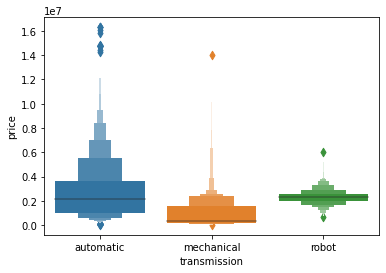

In [105]:
sns.boxenplot(x='transmission', y ='price', data=df)

Средняя цена за машину с механической коробкой передач чуть ниже, а у роботизированной самая высокая.  
Тем не менее, цена за автомат часто сильно превышает цену за любоую другую коробку передач

In [106]:
def transmission_to_range(x):
    if not x or x == "None":
        return None
    if x.strip() == 'mechanical':
        return 0
    if x.strip() == 'automatic':
        return 1
    if x.strip() == 'robot':
        return 2
#     return None

df.transmission = df.transmission.apply(transmission_to_range)

Сразу же создами функцию для добавления дамми к нашему датафрейму, нам точно понадобится эта функция ниже

In [107]:
def to_dummies(df, column):
    dummie_column = pd.get_dummies(column)
    return pd.concat([df, dummie_column], axis=1)

In [108]:
# поскольку почти все машины имеют автоматическую коробку передач, просто заменим пропуски эти значением
df.transmission = df.transmission.fillna(df.transmission.value_counts().index[0])

### Признак 14: ownersNumber

In [109]:
print(f'Количество пропусков: {len(df) - df.ownersNumber.count()}')

Количество пропусков: 6149


In [110]:
# проверим в какои именно датафрейме много пропусков
print(len(auto_ru_df) - auto_ru_df['Владельцы'].count())
print(len(drom_ru_df) - drom_ru_df['Владельцы'].count())
print(len(avito_df) - avito_df['Владельцы'].count())
print(len(car_ru_df) - car_ru_df['Владельцы'].count())

2368
1146
0
2635


In [111]:
# взглянем на данные
df.ownersNumber.unique()

array([2.0, 1.0, nan, 3.0, '1 запись', '3 записи', '2 записи', '4 записи',
       '10 записей', '7 записей', '8 записей', '5 записей', '6 записей',
       '9 записей', '12 записей', '11 записей', '14 записей',
       '16 записей', '2', '4+ ', '1', '3', 'None', '1\xa0владелец',
       '2\xa0владельца', '3 или более'], dtype=object)

Данные грязные, нужно унифицировать значения, превратив в числа  

Кроме того, пустые ячейки имеют строковое значение "None", переделаем его в тип None

In [112]:
def owners_unification(x):
    if not x or x == "None":
        return None
    if isinstance(x, int):
        return x
    if isinstance(x, float) and not pd.isna(x):
        return int(x)
    if isinstance(x, str):
        return int(x.split()[0].strip('+'))
    
df.ownersNumber = df.ownersNumber.apply(owners_unification)

Есть множество пропусков в поле "Владельцы".
Эта переменная сильно коррелирует с пробегом, значит можно заполить пропуски, описаясь на пробег(чем он больше, тем скорее всего больше владельцев). В таком случае надо знать спустя сколько км/месяцев (среднестатистически) решают продать.  
После обработки признака пробега, заполним пропуски, а пока к следующему признаку

### Признак 15: owningPeriod

In [113]:
print(f'Количество пропусков: {len(df) - df.owningPeriod.count()}')

Количество пропусков: 6943


Слишком много пропусков, столбец можно удалить

In [114]:
df = df.drop('owningPeriod', axis=1)

### Признак 16: complectation

- Первый вариант обработки этого стобца прост: измерить количество предметов комплектации и заполнить признак категорией (например, базовая компактация или максимальная), в зависимости от кол-ва деталей,   
- Второй - извлекать текстовую информацию, проверяя, например, наличие климат-контроля и обогрева стекол, и по этим параметрам относить машину к категории  
Данный признак содержит много пропусков, поэтому заполнять пропущенные зеачения мы будем, опираясь на поле "descriotion"

In [115]:
print(f'Количество пропусков complectation: {len(df) - df.complectation.count()}')
print(f'Количество пропусков в description: {len(df) - df.description.count()}')

Количество пропусков complectation: 6420
Количество пропусков в description: 216


In [116]:
import re

# base = re.compile("гидроусилител[а-я]*|гидро-усилител[а-я]*|abs|абс|антиблокировочн[а-я]*|анти-блокировочн[а-я]*|электроподъемник[а-я]*|электро-подъемник[а-я]*|climate|климат[а-я]*|климат-контроль[а-я]*|климатконтрол[а-я]*|подогрев[а-я]*|аудио[а-я]*|аудиосистем[а-я]*|аудио-систем[а-я]*|кондиционер[а-я]*|bas|ebd|bas|esp|[а-я]*грев[а-я]*|базов[а-я]*|стандартн[а-я]*|мультируль[а-я]*")
maxim = re.compile("hands[a-z]*|hands-free[a-z]*|кож[а-я]*|premium|преми[а-я]*|дерев[а-я]*|бесключ[а-я]*|ключ[а-я]*|полн[а-я]*|круиз-контрол[а-я]*|круизконтрол[а-я]*|[а-я]*грев[а-я]*|мультируль[а-я]*|multi-wheel[a-z]*sport-seats[a-z]*|cruise-control[a-z]*|electro-mirrors[a-z]*|driver-seat-memory[a-z]*|датчик[а-я]*|rain-sensor[a-z]*|mirrors-heat[a-z]*|keyless-entry|voice-recognition[a-z]*|голосовое[а-я]*|panorama-roof[a-z]*")


def coplectation_unification(row):
    if not isinstance(row['description'], str):
        return None
    else:
        for i in str(row['description']).split():
            if maxim.match(i.lower().strip(',').strip(' ').strip(')').strip('(').strip('.')):
                return 'maxim'
            for j in str(row['complectation']).split():
                if maxim.match(j.lower().strip(',').strip(' ').strip(')').strip('(').strip('.')):
                    return 'maxim'
            return 'base'
    return 'base'
            
        
df['complectation'] = df.apply(coplectation_unification, axis=1)

# df['complectation'] = df['complectation'].fillna(df.complectation.value_counts().index[0])

In [117]:
df['complectation'] = df['complectation'].fillna(df.complectation.value_counts().index[0])
df['complectation'].value_counts()

base     17758
maxim     3338
Name: complectation, dtype: int64

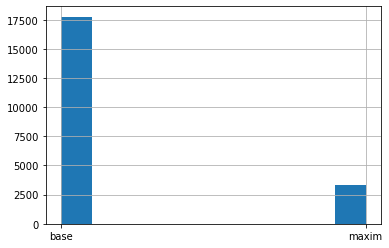

In [118]:
df.complectation.hist()

### Следующий признак - ПТС

In [119]:
print(f'Основные значения:\n\n{df.PTC.value_counts()}')

Основные значения:

ORIGINAL     7484
None         3938
Оригинал     3463
DUPLICATE     907
Дубликат      374
Name: PTC, dtype: int64


In [120]:
print(f'Количество пропусков, не учитывая строковое None: {len(df) - df.PTC.count()}')

Количество пропусков, не учитывая строковое None: 4930


In [121]:
# преобразуем признак

def ptc_unif(x):
    if str(x).split()[0].lower() in ['original', 'оригинал']:
        return 'original_ptc'
    elif str(x).split()[0].lower() in ['duplicate', 'дубликат']:
        return 'dublicate_ptc'
    else:
        return None

In [122]:
df.PTC = df.PTC.apply(ptc_unif)
df.PTC.value_counts()

original_ptc     10947
dublicate_ptc     1281
Name: PTC, dtype: int64

In [123]:
print(f'Общее количество пропусков: {len(df) - df.PTC.count()}')

Общее количество пропусков: 8868


In [124]:
# проверим действительно ли у новых машин нет птс

print(f'У {df[df.new == 1].PTC.value_counts().iloc[0]} новых машин есть ПТС')
print(f'У {(len(df[df.new == 1]) - (df[df.new == 1].PTC.value_counts().iloc[0]))} новых машин нет ПТС')


У 2231 новых машин есть ПТС
У 3517 новых машин нет ПТС


In [125]:
VERSION    = 11
DIR_UNITED_DF  = '../input/sf-autoru-solve-v4/' # подключил к ноутбуку свой внешний датасет


- У большинства нрвых машин нет ПТС, можно попробовать заполнить пропуски признака ПТС у новых маши значением "отсутсвует"

- Оригинальных ПТС сильно больше, а значит можно заполнить пропуски поддержанных этой группой (1)

In [126]:
print(f'У {round(df.PTC.value_counts()[1] * 100 / df.PTC.value_counts()[0], 1)}% машин дубликат ПТС')

У 11.7% машин дубликат ПТС


Это небольшой процент, поэтому можно:
1. заполнить пропуски значением "original"
2.  заполнить пропуски значением "отсутсвует", если машина еще и новая

In [127]:
def ptc_unif(row):
    if pd.isna(row['PTC']):        
        if row['new'] == 1:
            return 'no_ptc_new_car'
        return 'original_ptc'
    else:
        return row['PTC']

df.PTC = df.apply(ptc_unif, axis=1)

### Признак 18: drive

Как всегда, посмотрим на основные значения и на пропуски:

In [128]:
list_of_drive_values = df.drive.value_counts().index

print(f'Количество пропусков, не учитывая строковое None: {len(df) - df.drive.count()}')
print(list_of_drive_values)

Количество пропусков, не учитывая строковое None: 0
Index(['ALL_WHEEL_DRIVE', 'полный', 'REAR_DRIVE', 'полный ', '4WD', 'задний',
       'задний ', 'не указано', 'FORWARD_CONTROL', 'передний', 'передний ',
       'none'],
      dtype='object')


In [129]:
# унифицируем

def drive_unification(x):
    if str(x).split()[0].lower().strip() in ['all_wheel_drive', 'полный', '4wd']:
        return 'all_wheel'
    elif str(x).split()[0].lower().strip() in ['передний', 'forward_control']:
        return 'forward'
    elif str(x).split()[0].lower().strip() in ['задний', 'rear_drive']:
        return 'back'
    else:
        return None

In [130]:
df.drive = df.drive.apply(drive_unification)

In [131]:
df.drive.value_counts()

all_wheel    14170
back          6079
forward        362
Name: drive, dtype: int64

In [132]:
print(f'Общее количество пропусков: {len(df) - df.drive.count()}')

Общее количество пропусков: 485


In [133]:
df.drive = df.drive.fillna(df.drive.value_counts().index[0])

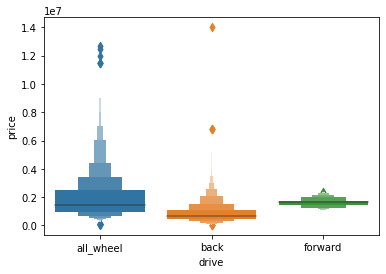

In [134]:
sns.boxenplot(x='drive', y='price', data=df.dropna())

Разница в цене не явная, возможно, машины с задним приводом чуть дешевле.
Самое частое значение - полная (все колеса). Пропуски можно заполнить эти значением.
Можно зделать признак рагновым, назначив 0 для машин с задним приводом, 1 для полного и 2 для переднего.

In [135]:
# def drive_ro_range(x):
#     if x == 'back':
#         return 0
#     if x == 'all_wheel':
#         return 1
#     if x == 'forward':
#         return 2
#     return None
    
# df.drive = df.drive.apply(drive_ro_range)

# df = to_dummies(df, df.drive)

### Признак 19: steeringWheelSide (сторона руля)

In [136]:
print(f'Количество пропусков, не учитывая строковое None: {len(df) - df.steeringWheelSide.count()}')
print(df.steeringWheelSide.value_counts())

Количество пропусков, не учитывая строковое None: 0
LEFT       8462
Левый      6060
левый      3928
левый      2628
правый        8
none          4
правый        3
None          2
RIGHT         1
Name: steeringWheelSide, dtype: int64


In [137]:
# унифицируем

def wheel_side_unification(x):
    if str(x).split()[0].lower().strip() in ['left', 'левый']:
        return 0
    elif str(x).split()[0].lower().strip() in ['правый', 'right']:
        return 1
    else:
        return None

In [138]:
df.steeringWheelSide = df.steeringWheelSide.apply(wheel_side_unification)

In [139]:
print(df.steeringWheelSide.value_counts())
print(f'Общее количество пропусков: {len(df) - df.steeringWheelSide.count()}')

0.0    21078
1.0       12
Name: steeringWheelSide, dtype: int64
Общее количество пропусков: 6


Почти у всех машин левый руль, признак можно и удалить, но пока:

In [140]:
# заполним пропуски самым частым значением 
df.steeringWheelSide = df.steeringWheelSide.fillna(df.steeringWheelSide.value_counts().index[0])

### Признак 20: state

In [141]:
print(f'Количество пропусков, не учитывая строковое None: {len(df) - df.state.count()}')
print(df.state.value_counts())

Количество пропусков, не учитывая строковое None: 2223
True                  8463
Не требует ремонта    3837
не битый              2967
новый                 2319
None                   896
отличное               292
битый                   75
хорошее                 22
среднее                  2
Name: state, dtype: int64


3 варианта: 
- сделать dummy (удовлетворительное сотояние/новый или в отличном состянии/битый)
- сделать бинарным (битый/небитый)
- сделать ранговым

Самым подходящим пока видится вариант 3

In [142]:
# сделать категориальный 1, 2, 3

def state_unification(x):
    if str(x).lower().strip() in ['true', 'не требует ремонта', 'не битый', 'хорошее', 'среднее']:
        return 1
    elif str(x).lower().strip() in ['новый', 'отличное']:
        return 2
    if str(x).lower().strip() == 'битый':
        return 0
    else:
        return None

In [143]:
df.state = df.state.apply(state_unification)

In [144]:
df.state.value_counts()

1.0    15291
2.0     2611
0.0       75
Name: state, dtype: int64

In [145]:
# заполним пропуски самым частотным значением
df.state = df.state.fillna(df.state.value_counts().index[0])

In [146]:
# добавим новый признак - авто битый

def crashed_car(row):
    if row['state'] == 0:
        return 1
    return 0

df['crashed_car'] = df.apply(crashed_car, axis=1)

### Признак "цена"

Мы уже очистили его

In [147]:
autoru = df[df.source == 'auto_ru']
avito = df[df.source == 'avito_df']
dromru = df[df.source == 'drom_ru_df']
carsru = df[df.source == 'cars_ru_df']

print(f'Количество пропусков в данных с auto.ru: {len(autoru) - autoru.price.count()}') 
print(f'Количество пропусков в данных с avito: {len(avito) - avito.price.count()}') 
print(f'Количество пропусков в данных с drom.ru: {len(dromru) - dromru.price.count()}') 
print(f'Количество пропусков в данных с car.ru: {len(carsru) - carsru.price.count()}') 


Количество пропусков в данных с auto.ru: 0
Количество пропусков в данных с avito: 0
Количество пропусков в данных с drom.ru: 0
Количество пропусков в данных с car.ru: 0


count    1.725900e+04
mean     2.732630e+06
std      2.296620e+06
min      3.000000e+04
25%      9.500000e+05
50%      2.272417e+06
75%      3.649000e+06
max      1.629000e+07
Name: price, dtype: float64
950000.0     135
1100000.0    131
1200000.0    121
900000.0     115
850000.0     114
            ... 
2954315.0      1
1084000.0      1
2692332.0      1
5737000.0      1
3539000.0      1
Name: price, Length: 3613, dtype: int64
25-й перцентиль: 950000.0, 75-й перцентиль: 3649000.0, IQR: 2699000.0, границы выбросов: [-3098500.0, 7697500.0].


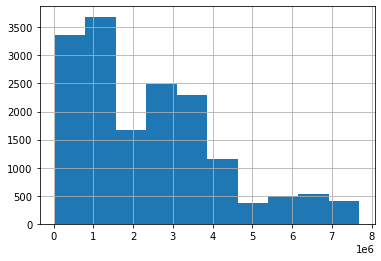

In [148]:
# посмотрим на наличие выбросов
print(df.price.describe())
print(df.price.value_counts())

median = df.price.median()
IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
perc25 = df.price.quantile(0.25)
perc75 = df.price.quantile(0.75)

print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}].')

df.price.loc[df.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(label = 'IQR')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   description         20880 non-null  object 
 4   engineDisplacement  21096 non-null  int64  
 5   enginePower         21096 non-null  int64  
 6   fuelType            21096 non-null  object 
 7   mileage             21096 non-null  int64  
 8   modelDate           16238 non-null  object 
 9   name                21096 non-null  object 
 10  numberOfDoors       21096 non-null  int64  
 11  productionDate      21096 non-null  int64  
 12  transmission        21096 non-null  float64
 13  ownersNumber        14051 non-null  float64
 14  complectation       21096 non-null  object 
 15  PTC                 21096 non-null  object 
 16  driv

Есть множество пропусков в поле "Владельцы". Эта переменная сильно коррелирует с пробегом, значит можно заполить пропуски, описаясь на пробег(чем он больше, тем скорее всего больше владельцев). В таком случае надо знать спустя сколько км/месяцев (среднестатистически) решают продать.

In [150]:
print(f'Средний пробег у 1 владельца: {round(df[df.ownersNumber == 1].mileage.mean())}')
print(f'Средний пробег у 2 владельцев: {round(df[df.ownersNumber == 2].mileage.mean())}')
print(f'Средний пробег у 3 владельцев: {round(df[df.ownersNumber == 3].mileage.mean())}')
print(f'Средний пробег у 4 владельцев: {round(df[df.ownersNumber == 4].mileage.mean())}')
print(f'Средний пробег у 5-7 владельцев: {round(df[(5 <= df.ownersNumber) & (df.ownersNumber <= 7)].mileage.mean())}')
print(f'Средний пробег у 7+ владельцев: {round(df[df.ownersNumber > 7].mileage.mean())}')

Средний пробег у 1 владельца: 71210
Средний пробег у 2 владельцев: 120539
Средний пробег у 3 владельцев: 180917
Средний пробег у 4 владельцев: 208746
Средний пробег у 5-7 владельцев: 178720
Средний пробег у 7+ владельцев: 225727


In [151]:
# заполняем пропуски
# в среднем люди продают машину, проехав 100000

def owners_gap_fill(row):
    if pd.isna(row['ownersNumber']):
        if row['mileage'] <= 10000 and row['productionDate'] == 2020:
            return 0
        if row['mileage'] <= 80000 and 2012 <= row['productionDate'] <= 2020:
            return 1
        if row['mileage'] <= 150000:
            return 2
        if row['mileage'] <= 190000:
            return 3
        if row['mileage'] <= 250000:
            return 4
        if row['mileage'] <= 250000 and 1900 <= row['productionDate'] <= 2000:
            return 5
        return 6
    return row['ownersNumber']


df.ownersNumber = df.apply(owners_gap_fill, axis=1)

# налог
СУММА
НАЛОГА
(РУБ.)
=
НАЛОГОВАЯ
БАЗА(лошад. силы)
*
СТАВКА
(РУБ.)
*
(КОЛИЧЕСТВО
ПОЛНЫХ МЕСЯЦЕВ
ВЛАДЕНИЯ
/ 12 МЕСЯЦЕВ)

In [152]:
def tax(row):
    return row['enginePower'] * 75 * (row['carAge']*12)

df['tax'] = df.apply(tax, axis=1)

Еще раз посмотрим на данные

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   description         20880 non-null  object 
 4   engineDisplacement  21096 non-null  int64  
 5   enginePower         21096 non-null  int64  
 6   fuelType            21096 non-null  object 
 7   mileage             21096 non-null  int64  
 8   modelDate           16238 non-null  object 
 9   name                21096 non-null  object 
 10  numberOfDoors       21096 non-null  int64  
 11  productionDate      21096 non-null  int64  
 12  transmission        21096 non-null  float64
 13  ownersNumber        21096 non-null  float64
 14  complectation       21096 non-null  object 
 15  PTC                 21096 non-null  object 
 16  driv

Оказывается, еще остались пропуски в bodyType, заполним их.

In [154]:
# df.bodyType = df.bodyType.fillna(df.bodyType.value_counts().index[0])

In [155]:
df[df.numberOfDoors == 'none'].bodyType.value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Series([], Name: bodyType, dtype: int64)

In [156]:
df[df.bodyType == 'внедорожник'].numberOfDoors.value_counts()

5    9462
Name: numberOfDoors, dtype: int64

In [157]:
# df.numberOfDoors = df.numberOfDoors.apply(lambda x: 5 if x == 'none' else x)

In [158]:
float_data_columns = [
#     'engineDisplacement',
#     'enginePower',
#     'mileage',
#     'price',
    'numberOfDoors',
    'ownersNumber',
    'state',
    'steeringWheelSide',
    'transmission',
    'carAge',
    'tax',
]


for column in float_data_columns:
    df[column] = df[column].apply(lambda x: int(x))

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   description         20880 non-null  object 
 4   engineDisplacement  21096 non-null  int64  
 5   enginePower         21096 non-null  int64  
 6   fuelType            21096 non-null  object 
 7   mileage             21096 non-null  int64  
 8   modelDate           16238 non-null  object 
 9   name                21096 non-null  object 
 10  numberOfDoors       21096 non-null  int64  
 11  productionDate      21096 non-null  int64  
 12  transmission        21096 non-null  int64  
 13  ownersNumber        21096 non-null  int64  
 14  complectation       21096 non-null  object 
 15  PTC                 21096 non-null  object 
 16  driv

In [160]:
# удаляем данные, которые не будем использовать (преобразовали в дамми), а также те колонки, которые были обработаны ранее, в первой части дф

df = df.drop([
    'description',
    'modelDate',
    'name',
    'productionDate',
#     'steeringWheelSide'
], axis=1)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   engineDisplacement  21096 non-null  int64  
 4   enginePower         21096 non-null  int64  
 5   fuelType            21096 non-null  object 
 6   mileage             21096 non-null  int64  
 7   numberOfDoors       21096 non-null  int64  
 8   transmission        21096 non-null  int64  
 9   ownersNumber        21096 non-null  int64  
 10  complectation       21096 non-null  object 
 11  PTC                 21096 non-null  object 
 12  drive               21096 non-null  object 
 13  steeringWheelSide   21096 non-null  int64  
 14  state               21096 non-null  int64  
 15  source              21096 non-null  object 
 16  pric

## Построение корреляционной матрицы для числовых переменных

In [162]:
correlation_data = df[['engineDisplacement', 'carAge',
       'enginePower', 'mileage',
       'price']].dropna()

In [163]:
corr = correlation_data.corr(method='pearson')
corr

engineDisplacement    carAge  enginePower   mileage  \
engineDisplacement            1.000000  0.178148     0.851777  0.156788   
carAge                        0.178148  1.000000    -0.064684  0.817131   
enginePower                   0.851777 -0.064684     1.000000 -0.059835   
mileage                       0.156788  0.817131    -0.059835  1.000000   
price                         0.175067 -0.585608     0.351352 -0.617298   

                       price  
engineDisplacement  0.175067  
carAge             -0.585608  
enginePower         0.351352  
mileage            -0.617298  
price               1.000000

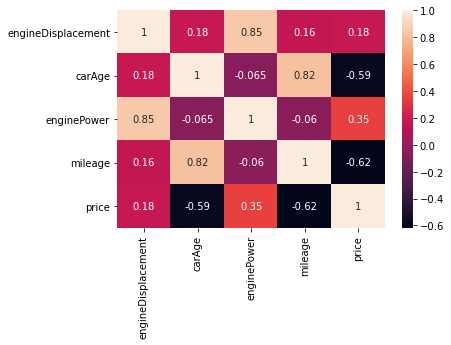

In [164]:
sns.heatmap(corr, annot=True) #cmap = 'coolwarm'

#### Самые большие корреляции с ценой по абсолютному значению у признаков mileage (пробег) и carAge (возраст машины)

### Построение графиков-боксплотов для категориальных переменных

In [165]:
def get_boxplot(column):
    fig, ax = plt.subplots()
    sns.boxenplot(x=column, y='price', 
                data=df, width= 0.8)
    ax.set_title('Boxplot for ' + column)
    plt.show()

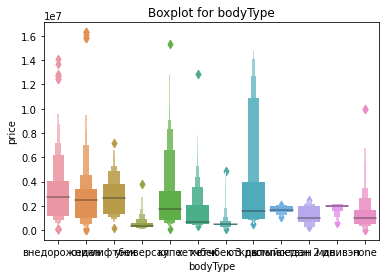

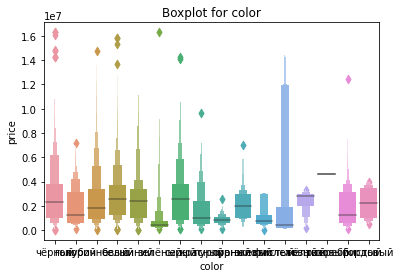

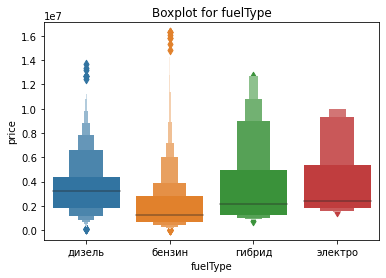

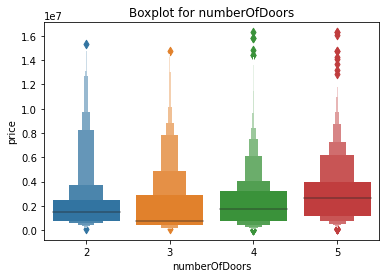

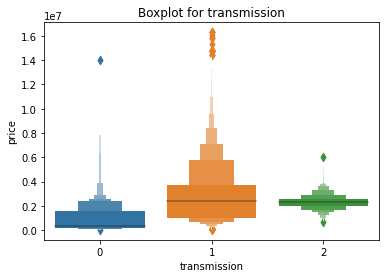

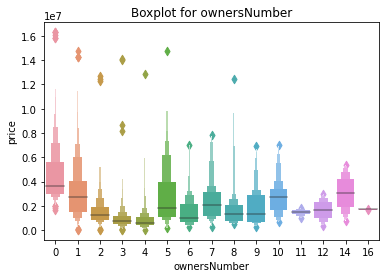

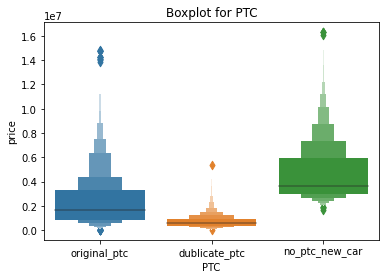

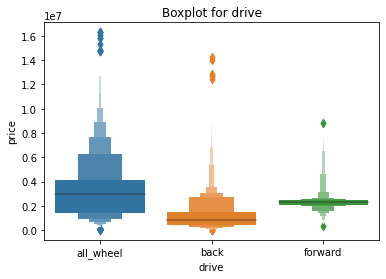

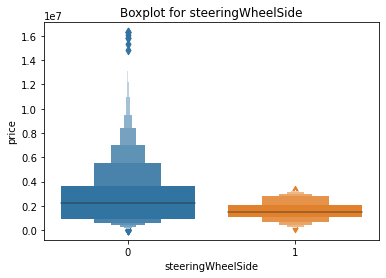

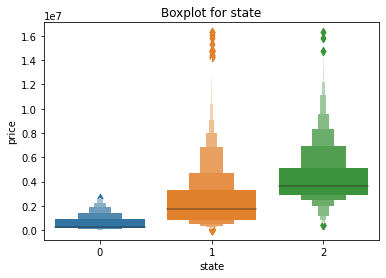

In [166]:
for col in ['bodyType', 'color', 'fuelType', 'numberOfDoors', 'transmission',
            'ownersNumber','PTC', 'drive', 'steeringWheelSide', 'state']:
    get_boxplot(col)

#### Выводы: 
1. Значения признаков  bodyType и color рекомендуется объединить в более крупные категории
2. Число владельцев можно разбить на значения: 1, 2, 3, 4, 5 и более.

### Тест Стьюдента для категориальных переменных

In [167]:
from itertools import combinations
from scipy.stats import ttest_ind

In [168]:
def get_stat_dif(column, df):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break  

In [169]:
for col in ['bodyType', 'color', 'fuelType', 'numberOfDoors', 'transmission',
            'ownersNumber','PTC', 'drive', 'steeringWheelSide', 'state']:
    get_stat_dif(col, df)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки transmission
Найдены статистически значимые различия для колонки ownersNumber
Найдены статистически значимые различия для колонки PTC
Найдены статистически значимые различия для колонки drive
Найдены статистически значимые различия для колонки state


#### Выводы:
1. Признак 'steeringWheelSide' (сторона руля) можно удалить
2. Оставить в дальнейшей работе: 'bodyType', 'color', 'fuelType', 'numberOfDoors', 'transmission','ownersNumber','PTC', 'drive'  'state'

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   engineDisplacement  21096 non-null  int64  
 4   enginePower         21096 non-null  int64  
 5   fuelType            21096 non-null  object 
 6   mileage             21096 non-null  int64  
 7   numberOfDoors       21096 non-null  int64  
 8   transmission        21096 non-null  int64  
 9   ownersNumber        21096 non-null  int64  
 10  complectation       21096 non-null  object 
 11  PTC                 21096 non-null  object 
 12  drive               21096 non-null  object 
 13  steeringWheelSide   21096 non-null  int64  
 14  state               21096 non-null  int64  
 15  source              21096 non-null  object 
 16  pric

In [171]:
# преобразуем неотрые признаки в категоривальные

def drive_to_cat(x):
    if x == 'back':
        return 0
    if x == 'forward':
        return 1
    return 2

def ptc_to_cat(x):
    if x == 'original_ptc':
        return 1
    if x == 'dublicate':
        return 0
    return 2

df.PTC = df.PTC.apply(ptc_to_cat)
df.complectation = df.complectation.apply(lambda x: 1 if x == 'maxim' else 0)
df.drive = df.drive.apply(drive_to_cat)

In [172]:
# а некоторые в дамми
# def to_dummies(df, column):
#     dummie_column = pd.get_dummies(column)
#     return pd.concat([df, dummie_column], axis=1)

df = to_dummies(df, df.fuelType)
df =  to_dummies(df, df.bodyType)
df =  to_dummies(df, df.modelName)
df =  to_dummies(df, df.color)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21096 entries, 0 to 21097
Data columns (total 73 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21096 non-null  int64  
 1   bodyType            20959 non-null  object 
 2   color               21096 non-null  object 
 3   engineDisplacement  21096 non-null  int64  
 4   enginePower         21096 non-null  int64  
 5   fuelType            21096 non-null  object 
 6   mileage             21096 non-null  int64  
 7   numberOfDoors       21096 non-null  int64  
 8   transmission        21096 non-null  int64  
 9   ownersNumber        21096 non-null  int64  
 10  complectation       21096 non-null  int64  
 11  PTC                 21096 non-null  int64  
 12  drive               21096 non-null  int64  
 13  steeringWheelSide   21096 non-null  int64  
 14  state               21096 non-null  int64  
 15  source              21096 non-null  object 
 16  pric

In [174]:
df = df.drop([
    'id',
    'bodyType',
    'color',
    'steeringWheelSide',
    'fuelType',
    'modelName',
    'none',
], axis=1)

# Обучение

### Разделим на трейн и тест с помощью колонки source

In [175]:
train_df = df[df.source != 'test_dataset']
train_df = train_df.drop(['source'], axis=1)
train_df.price = train_df.price.apply(lambda x:int(x))

test_df = df[df.source == 'test_dataset']
#удаляем у тестовой части цену
test_df = test_df.drop(['price', 'source'], axis=1)

In [176]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

In [177]:
VERSION    = 11
# DIR_TRAIN  = '../test_df.csv/'
DIR = '../input/car-price-train-test-downloaded/'
DIR_SUB = '../input/sf-dst-car-price/'
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 10000
LR         = 0.001

In [178]:
train = pd.read_csv('./train_df.csv') # подготовленный датасет для обучения модели
test = pd.read_csv(DIR+'test_df.csv')
sample_submission = pd.read_csv(DIR_SUB+'sample_submission.csv')

In [179]:
# располагаем колонки в удобном порядке
train = train[['engineDisplacement', 'enginePower', 'mileage', 'numberOfDoors', 'transmission', 'ownersNumber', 'complectation', 'PTC', 'drive', 'state', 'new', 'carAge', 'crashed_car', 'tax',
               'бензин', 'гибрид', 'дизель', 'электро', 'внедорожник', 'компактвэн', 'купе', 'лифтбек', 'минивэн', 'открытый', 'седан', 'седан 2 дв.', 'универсал', 'хетчбек', 'хетчбек 3 дв.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'C', 'E', 'M', 'N', 'X', 'i', 'n', 's', 'белый', 'бордовый', 'голубой', 'жёлтый', 'зелёный', 'золотистый', 'коричневый', 'красный', 'оранжевый', 'пурпурный', 'розовый', 'серебристый', 'серый', 'синий', 'фиолетовый', 'чёрный', 'price']]

In [180]:
train

engineDisplacement  enginePower  mileage  numberOfDoors  transmission  \
0                      20          177   164000              5             1   
1                      44          575    13500              5             1   
2                      20          184   135000              5             1   
3                      30          306    89000              5             1   
4                      20          184   146000              5             1   
...                   ...          ...      ...            ...           ...   
17254                  44          575        0              5             1   
17255                  20          190        0              4             1   
17256                  20          157    97921              4             1   
17257                  20          150        0              5             1   
17258                  19          190        0              4             1   

       ownersNumber  complectation  PTC  drive  state  new  carAge  \
0                 2              0    1      2      1    0       8   
1                 1              0    1      2      1    0       2   
2                 2              0    1      2      1    0       8   
3                 2              0    1      2      1    0       6   
4                 2              0    1      2      1    0       6   
...             ...            ...  ...    ...    ...  ...     ...   
17254             1              0    1      2      2    0       1   
17255             1              0    1      2      2    0       1   
17256             2              0    1      2      2    0       9   
17257             1              0    1      2      2    0       1   
17258             1              0    1      0      2    0       2   

       crashed_car      tax  бензин  гибрид  дизель  электро  внедорожник  \
0                0  1274400       0       0       1        0            1   
1                0  1035000       1       0       0        0            1   
2                0  1324800       0       0       1        0            1   
3                0  1652400       1       0       0        0            1   
4                0   993600       1       0       0        0            1   
...            ...      ...     ...     ...     ...      ...          ...   
17254            0   517500       1       0       0        0            1   
17255            0   171000       0       0       1        0            0   
17256            0  1271700       1       0       0        0            0   
17257            0   135000       0       0       1        0            1   
17258            0   342000       0       0       1        0            0   

       компактвэн  купе  лифтбек  минивэн  открытый  седан  ...  C  E  M  N  \
0               0     0        0        0         0      0  ...  0  0  0  0   
1               0     0        0        0         0      0  ...  0  0  0  1   
2               0     0        0        0         0      0  ...  0  0  0  0   
3               0     0        0        0         0      0  ...  0  0  0  0   
4               0     0        0        0         0      0  ...  0  0  0  0   
...           ...   ...      ...      ...       ...    ...  ... .. .. .. ..   
17254           0     0        0        0         0      0  ...  0  0  0  0   
17255           0     0        0        0         0      0  ...  0  0  0  0   
17256           0     0        0        0         0      1  ...  0  0  0  0   
17257           0     0        0        0         0      0  ...  0  0  0  0   
17258           0     0        0        0         0      1  ...  0  0  0  0   

       X  i  n  s  белый  бордовый  голубой  жёлтый  зелёный  золотистый  \
0      0  0  0  0      0         0        0       0        0           0   
1      0  0  0  0      0         0        1       0        0           0   
2      0  0  0  0      0         0        0       0        0           0   
3      0  0  0  0      0   

In [181]:
test

engineDisplacement  enginePower  mileage  numberOfDoors  transmission  \
0                     20          190   158836              4             1   
1                     20          150       10              4             1   
2                     44          407   120000              4             1   
3                     30          249   111466              5             1   
4                     30          381    11891              5             1   
...                  ...          ...      ...            ...           ...   
3832                  20          184    98000              4             1   
3833                  30          249   169615              5             1   
3834                  25          218   180000              4             1   
3835                  20          245   137500              4             1   
3836                  44          407    89905              5             1   

      ownersNumber  complectation  PTC  drive  state  new  carAge  \
0                1              1    1      0      1    0       3   
1                1              1    1      0      1    0       1   
2                2              1    1      2      1    0       8   
3                2              1    1      2      1    0       5   
4                1              1    1      2      1    0       1   
...            ...            ...  ...    ...    ...  ...     ...   
3832             3              1    1      0      1    0       7   
3833             1              1    1      2      1    0       4   
3834             3              1    1      2      1    0      14   
3835             3              1    1      2      1    0       8   
3836             1              0    1      2      1    0      10   

      crashed_car      tax  бензин  гибрид  дизель  электро  внедорожник  \
0               0   513000       0       0       1        0            0   
1               0   135000       0       0       1        0            0   
2               0  2930400       1       0       0        0            0   
3               0  1120500       0       0       1        0            1   
4               0   342900       0       0       1        0            1   
...           ...      ...     ...     ...     ...      ...          ...   
3832            0  1159200       1       0       0        0            0   
3833            0   896400       0       0       1        0            1   
3834            0  2746800       1       0       0        0            0   
3835            0  1764000       1       0       0        0            0   
3836            0  3663000       1       0       0        0            1   

      компактвэн  купе  лифтбек  минивэн  открытый  седан  ...  A  C  E  M  N  \
0              0     0        0        0         0      1  ...  0  0  0  0  0   
1              0     0        0        0         0      1  ...  0  0  0  0  0   
2              0     0        0        0         0      1  ...  0  0  0  0  0   
3              0     0        0        0         0      0  ...  0  0  0  0  0   
4              0     0        0        0         0      0  ...  0  0  0  1  0   
...          ...   ...      ...      ...       ...    ...  ... .. .. .. .. ..   
3832           0     0        0        0         0      1  ...  0  0  0  0  0   
3833           0     0        0        0         0      0  ...  0  0  0  0  0   
3834           0     0        0        0         0      1  ...  0  0  0  0  0   
3835           0     0        0        0         0      1  ...  0  0  0  0  0   
3836           0     0        0        0         0      0  ...  0  0  0  0  0   

      X  i  n  s  белый  бордовый  голубой  жёлтый  зелёный  золотистый  \
0     0  0  0  0      0         0        0       0        0           0   
1     0  0  0  0      1         0        0       0        0           0   
2     0  0  0  0      0         0        0       0        0           0   
3     0  0  0  0      1         0        0

## Data Preprocessing

In [182]:
X = train.drop(['price'], axis=1,)
y = train.price.values

## Train Split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Сat features

In [184]:
X_train.nunique()

engineDisplacement      33
enginePower            104
mileage               2347
numberOfDoors            4
transmission             3
ownersNumber            15
complectation            2
PTC                      2
drive                    3
state                    3
new                      2
carAge                  50
crashed_car              2
tax                    488
бензин                   2
гибрид                   2
дизель                   2
электро                  2
внедорожник              2
компактвэн               2
купе                     2
лифтбек                  2
минивэн                  2
открытый                 2
седан                    2
седан 2 дв.              2
универсал                2
хетчбек                  2
хетчбек 3 дв.            2
0                        2
1                        2
2                        2
3                        2
4                        2
5                        2
6                        2
7                        2
8

In [185]:
# Keep list of all categorical features in dataset to specify this for CatBoost
cat_features_ids = np.where(X_train.apply(pd.Series.nunique) < 3000)[0].tolist()

## Fit

In [186]:
# model = CatBoostRegressor(iterations = ITERATIONS,
#                           learning_rate = LR,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE']
#                          )
# model.fit(X_train, y_train,
#          cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=100,
#          use_best_model=True,
#          plot=True
#          )


ctb2 = CatBoostRegressor(loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.001,
                         iterations=15000,
                         l2_leaf_reg=2,
#                          depth=6,
                         bootstrap_type = 'Bayesian', # Bayesian Bernoulli
#                          subsample = 0.8,
                         one_hot_max_size = 5,
                         random_seed=42,
                         od_type='Iter',
                         od_wait=1000)

model = ctb2.fit(X_train, y_train,
                eval_set=(X_test, y_test),
                verbose_eval=1000,
                use_best_model=True,
                plot=True)
print(model)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4172733	test: 1.3727873	best: 1.3727873 (0)	total: 65.4ms	remaining: 16m 21s
1000:	learn: 0.6930430	test: 0.6561581	best: 0.6561581 (1000)	total: 5.74s	remaining: 1m 20s
2000:	learn: 0.4247048	test: 0.3902376	best: 0.3902376 (2000)	total: 11.9s	remaining: 1m 17s
3000:	learn: 0.3209552	test: 0.2886449	best: 0.2886449 (3000)	total: 18.3s	remaining: 1m 13s
4000:	learn: 0.2808326	test: 0.2499947	best: 0.2499947 (4000)	total: 25.2s	remaining: 1m 9s
5000:	learn: 0.2634903	test: 0.2349339	best: 0.2349339 (5000)	total: 33.4s	remaining: 1m 6s
6000:	learn: 0.2541817	test: 0.2277983	best: 0.2277983 (6000)	total: 41.3s	remaining: 1m 1s
7000:	learn: 0.2489200	test: 0.2239674	best: 0.2239674 (7000)	total: 50.2s	remaining: 57.3s
8000:	learn: 0.2450857	test: 0.2214688	best: 0.2214688 (8000)	total: 58.9s	remaining: 51.5s
9000:	learn: 0.2416039	test: 0.2193475	best: 0.2193475 (9000)	total: 1m 8s	remaining: 45.3s
10000:	learn: 0.2385591	test: 0.2175515	best: 0.2175515 (10000)	total: 1m 18s	re

In [187]:
model.save_model('catboost_first_model.model')

# Submission

In [188]:
predict_submission = model.predict(test)
predict_submission

array([1719834.92899547, 2491449.65342677, 1242015.35281531, ...,
        521439.76772763, 1046207.53188133, 1202057.56464118])

In [189]:
for i in range(len(predict_submission)):
    predict_submission[i] = predict_submission[i].astype('int64')
    predict_submission[i] = predict_submission[i] / 100
    predict_submission[i] = predict_submission[i].astype('int64')
    predict_submission[i] = predict_submission[i] * 100

In [190]:
predict_submission

array([1719800., 2491400., 1242000., ...,  521400., 1046200., 1202000.])

In [191]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v4.csv', index=False)
sample_submission.head()

id      price
0   0  1719800.0
1   1  2491400.0
2   2  1242000.0
3   3  2398000.0
4   4  6023000.0